In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms

In [2]:
class VAEModel(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAEModel, self).__init__()
        self.encoder = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_var = nn.Linear(400, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 400)
        self.decoder = nn.Linear(400, 784)

    def encode(self, x):
        x = F.relu(self.encoder(x))
        return self.fc_mu(x), self.fc_var(x)

    def reparameterize(self, mu, log_var):
        std = 0.5 * th.exp(log_var)
        eps = th.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.fc_decode(z))
        return th.sigmoid(self.decoder(x))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


In [3]:
def vae_loss(reconstructed, original, mu, log_var):
    recon_loss = F.binary_cross_entropy(reconstructed, original, reduction="sum")
    kl_divergence = -0.5 * th.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_divergence

In [4]:
# 加载和预处理MNIST数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = th.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
device = th.device("cuda" if th.cuda.is_available() else "cpu")
vae_model = VAEModel().to(device)
optimizer = th.optim.Adam(vae_model.parameters(), lr=0.0003)
num_epochs = 50

In [5]:
vae_model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_loader:
        images = th.flatten(images, start_dim=1).to(device)
        reconstructed_images, mu, log_var = vae_model(images)
        loss = vae_loss(reconstructed_images, images, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/50], Loss: -4461207.7754
Epoch [2/50], Loss: -3551884.2319
Epoch [3/50], Loss: -3514294.9270
Epoch [4/50], Loss: -4161113.7052
Epoch [5/50], Loss: -4658927.0101
Epoch [6/50], Loss: -5134707.7687
Epoch [7/50], Loss: -5469395.6802
Epoch [8/50], Loss: -5809885.3625
Epoch [9/50], Loss: -6070619.5405
Epoch [10/50], Loss: -6274602.3465
Epoch [11/50], Loss: -6455915.3571
Epoch [12/50], Loss: -6621626.4947
Epoch [13/50], Loss: -6766440.0011
Epoch [14/50], Loss: -6866472.2836
Epoch [15/50], Loss: -6957155.4190
Epoch [16/50], Loss: -7060023.2345
Epoch [17/50], Loss: -7143745.1748
Epoch [18/50], Loss: -7214006.5096
Epoch [19/50], Loss: -7264378.9829
Epoch [20/50], Loss: -7307377.3710
Epoch [21/50], Loss: -7359690.3817
Epoch [22/50], Loss: -7395993.4286
Epoch [23/50], Loss: -7425439.6333
Epoch [24/50], Loss: -7456723.8028
Epoch [25/50], Loss: -7484921.7932
Epoch [26/50], Loss: -7499168.5021
Epoch [27/50], Loss: -7526620.4648
Epoch [28/50], Loss: -7542996.9776
Epoch [29/50], Loss: -7566512

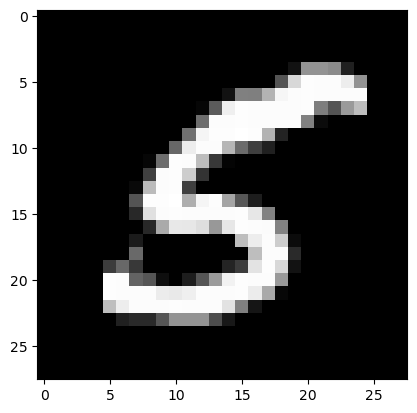

In [6]:
from matplotlib import pyplot as plt

image = images[14].view(1, 28, 28).cpu().numpy()
image = image.squeeze()
plt.imshow(image, cmap="gray")
plt.show()


In [7]:
from torchvision.utils import save_image


In [8]:
save_image(images.view(-1, 1, 28, 28), "images.png")
save_image(reconstructed_images.view(-1, 1, 28, 28), "reconstructed_images.png")


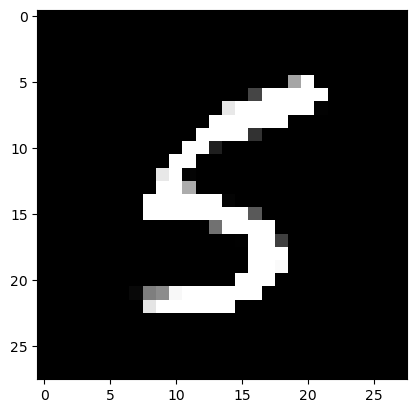

In [9]:
image = reconstructed_images[14].view(1, 28, 28).cpu().detach().numpy()
image = image.squeeze()
plt.imshow(image, cmap="gray")
plt.show()
